In [1]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List
from astropy.table import Table
from astropy.io import ascii

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

from gaia_download import gaia_get_dr2_in_dr3

from extinction import add_colors_and_abs_mag

Configuration file not found:

    /home/mjablons/.dustmapsrc

To create a new configuration file in the default location, run the following python code:

    from dustmaps.config import config
    config.reset()

Note that this will delete your configuration! For example, if you have specified a data directory, then dustmaps will forget about its location.


In [2]:
GAIA_EDR3_BIBCODE: str = '2020yCat.1350....0G'
WYIN_BIBCODE: str = '2008AJ....135.2264G'

In [3]:
RA: float = 11.7980
DEC: float = 85.2440
    
COLUMNS: List[str] = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
MIN_PARALLAX: float = 0.25
MAX_PARALLAX: float = 0.75
    
CLUSTER_NAME: str = 'NGC 188'
DEGREES: int = 1

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [4]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/2_deg.csv', index_col=None)

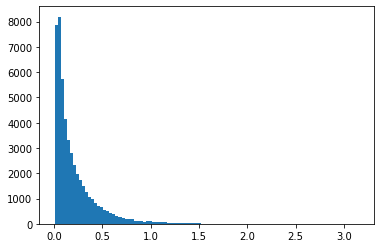

In [5]:
plt.hist(sources.parallax_error, bins=100);

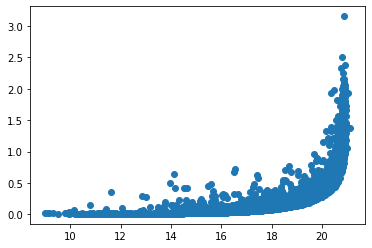

In [6]:
plt.scatter(sources.phot_g_mean_mag, sources.parallax_error)

In [7]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 574509467058245248,574509467058245248,1493410390,2016.0,35.762865,0.029851,85.164665,0.029967,0.545239,...,0.2303,0.2003,0.2590,0.1852,0.1610,0.2085,0.0981,0.0852,0.1104,MARCS
1,1636148068921376768,Gaia DR3 574509467058245632,574509467058245632,671685054,2016.0,35.689345,0.127046,85.157645,0.129013,0.276671,...,0.3949,0.3600,0.4324,0.2899,0.2639,0.3176,0.1549,0.1415,0.1696,MARCS
2,1636148068921376768,Gaia DR3 574509497122165760,574509497122165760,998946401,2016.0,35.790532,0.125888,85.170221,0.133328,0.700458,...,0.0185,0.0049,0.0432,0.0132,0.0035,0.0310,0.0071,0.0019,0.0167,PHOENIX
3,1636148068921376768,Gaia DR3 574509634560358272,574509634560358272,1157546964,2016.0,35.942416,0.145537,85.191924,0.142934,0.419366,...,0.0033,0.0008,0.0093,0.0024,0.0006,0.0068,0.0013,0.0003,0.0037,PHOENIX
4,1636148068921376768,Gaia DR3 574512555138118272,574512555138118272,1114709481,2016.0,35.841332,0.352966,85.192230,0.388702,0.268799,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocessing

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [8]:
def filter_by_parallax(sources: pd.DataFrame,
                       min_parallax: float,
                       max_parallax: float) -> pd.DataFrame:
    sources_par = sources[(sources['parallax']>min_parallax) & (sources['parallax']<max_parallax)]
    print(f'After parallax filtering: {len(sources_par)}')
    return sources_par

def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def normalize(sources: pd.DataFrame,
              columns: List[str],
              with_errors: bool = False) -> pd.DataFrame:
    scaler = StandardScaler()
    
    s = scaler.fit_transform(sources[columns])
    
    if with_errors:
        err_columns = [f'{c}_error' for c in columns]
        rescaled_errors = sources[err_columns].values*scaler.scale_
        s = np.concatenate([s, rescaled_errors], axis=1)
    return s

def prepare_data_for_clustering(sources: pd.DataFrame,
                                min_parallax: float,
                                max_parallax: float,
                                columns: List[str]) -> pd.DataFrame:
    return wrap_coordinates(
        clean_nans(
            filter_by_parallax(sources, min_parallax, max_parallax),
            columns
        )
    )

In [9]:
sources_to_cluster = prepare_data_for_clustering(sources, MIN_PARALLAX, MAX_PARALLAX, COLUMNS)
sources_normalized = normalize(sources_to_cluster, COLUMNS)

After parallax filtering: 49649
After dropping NaNs from ['ra', 'dec', 'parallax', 'pmra', 'pmdec']: 49649


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Normalization scales the features to an unit variance.

In [10]:
def plot_on_aitoff(sources: pd.DataFrame, cluster_name: str, degrees: float):
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources.ra,
                                          dec=sources.dec,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    plt.figure(figsize=(10, 7));
    plt.subplot(111, projection="aitoff");
    plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon',
                label=f'{cluster_name} center$\pm {degrees}^\circ$');
    plt.grid();
    plt.legend(loc='lower right', fontsize=14);

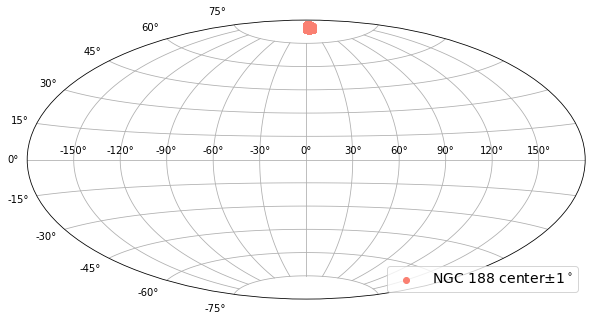

In [11]:
plot_on_aitoff(sources_to_cluster, CLUSTER_NAME, DEGREES)

# Comparision: NGC 188 cluster members from literature

In [12]:
from_lit: pd.DataFrame = pd.read_csv('./data/ngc_188/literature.csv').drop(columns='Unnamed: 0')
from_lit.head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
0,NGC 188 1054,303084,2004PASP..116.1012S,11.191250,85.256734,2020yCat.1350....0G,0.5409,0.0189,2020yCat.1350....0G,-2.178,...,3.0,2020yCat.1350....0G,-42.18,NaN,2008AJ....135.2264G,Gaia EDR3 573942325217383424|TIC 461601298|2MA...,573942325217383424,5.739423e+17,461601298.0,8
1,Cl* NGC 188 DGV 1869,303589,2004PASP..116.1012S,9.743203,85.559916,2020yCat.1350....0G,0.5191,0.0232,2020yCat.1350....0G,-2.250,...,3.0,2020yCat.1350....0G,-42.74,NaN,2008AJ....135.2264G,Gaia EDR3 573982010715088256|TIC 461597588|2MA...,573982010715088256,5.739820e+17,461597588.0,8
2,NGC 188 2014,303857,2004PASP..116.1012S,10.977598,85.205113,2020yCat.1350....0G,0.4785,0.0404,2020yCat.1350....0G,-2.368,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573935899946338816|TIC 461599220|2MA...,573935899946338816,5.739359e+17,461599220.0,6
3,NGC 188 1152,303904,2004PASP..116.1012S,11.164145,85.242850,2020yCat.1350....0G,0.6603,0.0853,2020yCat.1350....0G,-2.111,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941942962994176|TIC 461601256|2MA...,573941942962994176,5.739419e+17,461601256.0,3
4,NGC 188 3129,303875,2004PASP..116.1012S,11.151445,85.352770,2020yCat.1350....0G,0.5443,0.0169,2020yCat.1350....0G,-2.387,...,3.0,2020yCat.1350....0G,-42.69,NaN,2008AJ....135.2264G,Gaia EDR3 573944215002950144|TIC 461601456|2MA...,573944215002950144,5.739442e+17,461601456.0,8


# DBSCAN

In [3]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5, min_samples=20) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_fit = dbscan_clust.fit(sources)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels: {unique_labels}')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

In [4]:
def is_in_cluster_function(cluster_sources: pd.DataFrame,
                           source_id_col_name: str = 'source_id'):
    def is_in_cluster(source_id: int) -> bool:
        return len(cluster_sources[cluster_sources[source_id_col_name]==source_id]) > 0
    return is_in_cluster

In [15]:
def check_for_cluster_children(from_lit: pd.DataFrame,
                               cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(cluster_sources)
    in_cluster = np.vectorize(is_in_cluster)(from_lit['EDR3 id'].values)
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return in_cluster

def check_for_undiscovered_sources(from_lit: pd.DataFrame,
                                   cluster_sources: pd.DataFrame) -> bool:
    is_in_cluster = is_in_cluster_function(from_lit, 'EDR3 id')
    in_cluster = np.vectorize(is_in_cluster)(cluster_sources['source_id'].values)
    falses = in_cluster[~in_cluster]
    print(f'{len(falses)}/{len(in_cluster)} objects were previously unreported.')
    return len(falses)/len(in_cluster)

In [16]:
is_in_edr3 = is_in_cluster_function(sources_to_cluster)
from_lit_edr3 = from_lit[np.vectorize(is_in_edr3)(from_lit['EDR3 id'].values)]

In [2]:
labels = dbscan(sources_normalized, eps=.5, min_samples=200)
labelled_sources = label_sources(sources_to_cluster, labels)
clustered, noise = get_clustered_and_noise(labelled_sources, labels)

in_cluster = check_for_cluster_children(from_lit_edr3, clustered)
# undiscovered = check_for_undiscovered_sources(from_lit, clustered)

NameError: name 'dbscan' is not defined

In [18]:
from_lit_edr3[~in_cluster].reported.value_counts()

1    153
2      2
3      2
Name: reported, dtype: int64

In [19]:
from_lit_edr3[~in_cluster].link_bibcode.value_counts()

2008AJ....135.2264G    67
2018A&A...616A..10G    65
2018AJ....156..142D    22
2003AJ....126.2922P     1
2011AJ....142...59J     1
2013AJ....146..133M     1
Name: link_bibcode, dtype: int64

In [20]:
def cluster_plot(clustered_sources: pd.DataFrame,
                 noise_sources: pd.DataFrame,
                 paper_sources: pd.DataFrame):
    plt.figure(figsize=(20, 10))
    plt.scatter(clustered_sources.ra, clustered_sources.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
    plt.scatter(noise_sources.ra, noise_sources.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
    plt.scatter(paper_sources.ra, paper_sources.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
    lgnd = plt.legend(fontsize=14);
    plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
    plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

    for handle in lgnd.legendHandles:
        handle._sizes = [30];

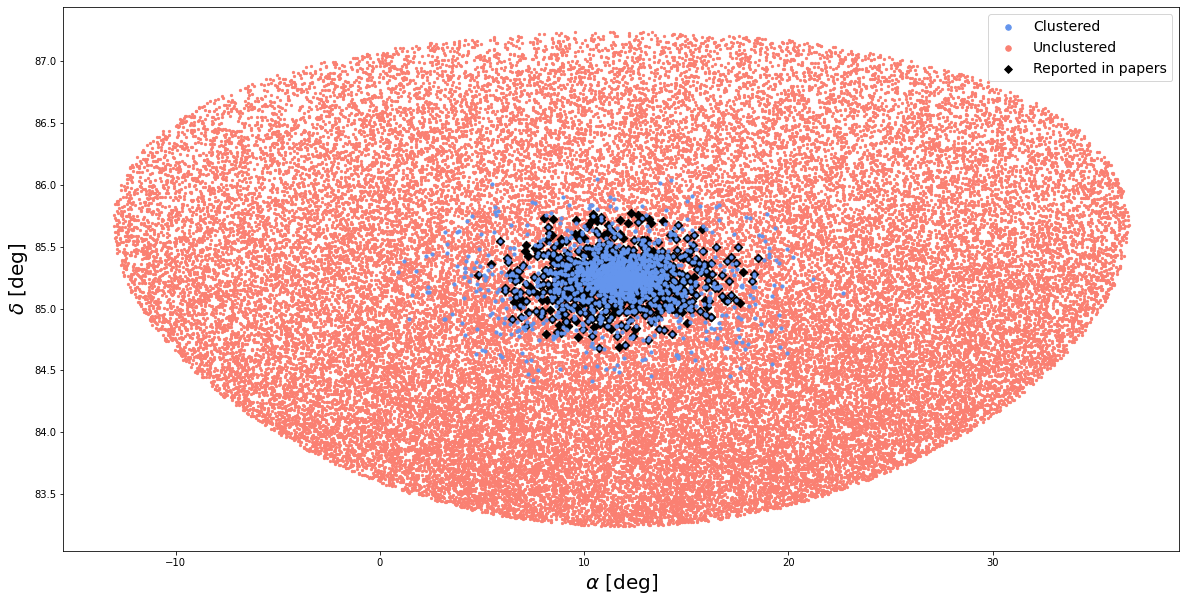

In [21]:
cluster_plot(clustered, noise, from_lit_edr3)

## DBSCAN with radial velocities

In [22]:
sources_with_radvel: pd.DataFrame = sources_to_cluster.dropna(subset=['radial_velocity'])
print(f'Sources with radial ')

Sources with radial 


In [23]:
clustered.to_csv('./data/ngc_188/dbscan_clustered.csv')

In [24]:
sources_normalized = normalize(sources_to_cluster, COLUMNS, True)
data = Table()
data['_x'] = sources_normalized[:, 0]
data['_y'] = sources_normalized[:, 1]
data['Plx'] = sources_normalized[:, 2]
data['pmRA'] = sources_normalized[:, 3]
data['pmDE'] = sources_normalized[:, 4]
data['e_Plx'] = sources_normalized[:, 7]
data['e_pmRA'] = sources_normalized[:, 8]
data['e_pmDE'] = sources_normalized[:, 9]
ascii.write(data, 'pyUPMASK/input/ngc_188.dat', overwrite=True) 

# pyUPMASK

In [25]:
pyupmask_clustered = ascii.read('pyUPMASK/output/ngc_188.dat').to_pandas()

In [26]:
len(pyupmask_clustered[pyupmask_clustered.probs_final>0.9])

1077

In [27]:
def contamination(sources: pd.DataFrame):
    return len(sources[(sources.dec<84.) | (sources.dec>86.) | (sources.ra<0) | (sources.ra>25)])

In [29]:
completness = []
efficiency = []
clustered = []
parallax_std = []
pmra_std = []
pmdec_std = []
contaminations = []

In [30]:
for threshold in np.linspace(0.5, 0.985, 20):
    print(f'Threshold {threshold}...')
    labels_pyupmask = (pyupmask_clustered.probs_final>threshold).astype(int).values-1

    labelled_sources_pyupmask = label_sources(sources_to_cluster,
                                              labels_pyupmask)
    clustered_pyupmask, noise_pyupmask = get_clustered_and_noise(labelled_sources_pyupmask,
                                                                 labels_pyupmask)
    
    clustered.append(len(clustered_pyupmask))

    r = check_for_cluster_children(from_lit_edr3, clustered_pyupmask)
    discovered = check_for_undiscovered_sources(from_lit_edr3, clustered_pyupmask)
    
    completness.append(len(from_lit_edr3[r])/len(from_lit_edr3))
    efficiency.append(discovered)
    parallax_std.append(np.std(clustered_pyupmask.parallax))
    pmra_std.append(np.std(clustered_pyupmask.pmra))
    pmdec_std.append(np.std(clustered_pyupmask.pmdec))
    contaminations.append(contamination(clustered_pyupmask))

Threshold 0.5...
Clustered: 21836/49649
1240/1327 objects found in the cluster.
20596/21836 objects were previously unreported.
Threshold 0.5255263157894737...
Clustered: 19579/49649
1235/1327 objects found in the cluster.
18344/19579 objects were previously unreported.
Threshold 0.5510526315789473...
Clustered: 17187/49649
1226/1327 objects found in the cluster.
15961/17187 objects were previously unreported.
Threshold 0.5765789473684211...
Clustered: 14532/49649
1212/1327 objects found in the cluster.
13320/14532 objects were previously unreported.
Threshold 0.6021052631578947...
Clustered: 11433/49649
1194/1327 objects found in the cluster.
10239/11433 objects were previously unreported.
Threshold 0.6276315789473684...
Clustered: 8301/49649
1174/1327 objects found in the cluster.
7127/8301 objects were previously unreported.
Threshold 0.6531578947368422...
Clustered: 5545/49649
1153/1327 objects found in the cluster.
4392/5545 objects were previously unreported.
Threshold 0.67868421

ValueError: attempt to get argmax of an empty sequence

In [31]:
thresholds = np.linspace(0.5, 0.985, 20)[:-1]

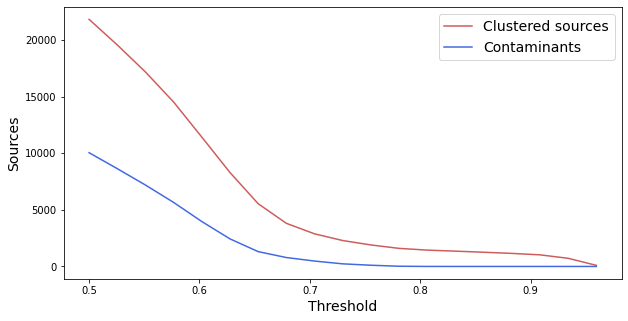

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, clustered, color='indianred', label='Clustered sources');
plt.plot(thresholds, contaminations, color='royalblue', label='Contaminants');
plt.gca().set_xlabel('Threshold', fontsize=14);
plt.gca().set_ylabel('Sources', fontsize=14);
plt.legend(loc='upper right', fontsize=14);

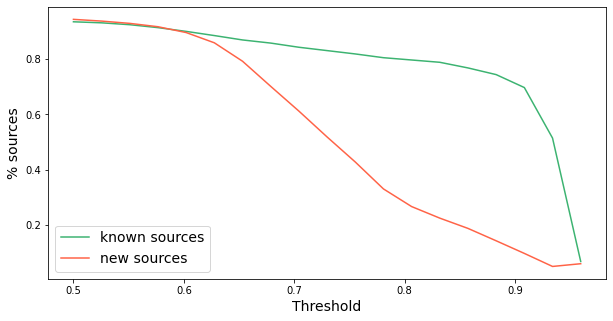

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, completness, color='mediumseagreen', label='known sources')
plt.plot(thresholds, efficiency, color='tomato', label='new sources')
plt.gca().set_xlabel('Threshold', fontsize=14);
plt.gca().set_ylabel('% sources', fontsize=14);
plt.legend(loc='lower left', fontsize=14);

In [34]:
np.where(np.array(contaminations)==0)

(array([13, 14, 15, 16, 17, 18]),)

In [35]:
thresholds[13]

0.8318421052631579

In [28]:
CLUSTER_THRESHOLD: float = 0.83
labels_pyupmask = (pyupmask_clustered.probs_final>CLUSTER_THRESHOLD).astype(int).values-1
    
labelled_sources_pyupmask = label_sources(sources_to_cluster,
                                          labels_pyupmask)
clustered_pyupmask, noise_pyupmask = get_clustered_and_noise(labelled_sources_pyupmask,
                                                             labels_pyupmask)

r = check_for_cluster_children(from_lit_edr3, clustered_pyupmask)

Clustered: 1358/49649
1047/1327 objects found in the cluster.


In [29]:
clustered_pyupmask.to_csv('./data/ngc_188/pyupmask_clustered.csv', index=None)

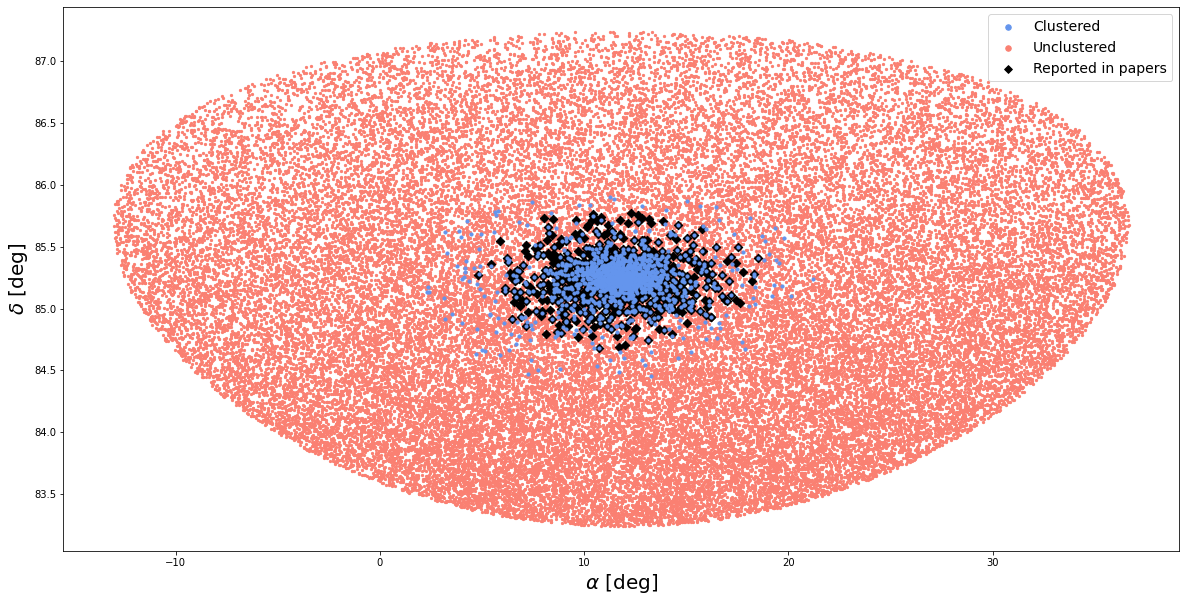

In [30]:
cluster_plot(clustered_pyupmask, noise_pyupmask, from_lit_edr3)

In [31]:
not_found = from_lit_edr3[~r]

In [32]:
len(not_found)

280

In [33]:
not_found.link_bibcode.value_counts()

2018A&A...616A..10G    161
2008AJ....135.2264G     72
2018AJ....156..142D     23
2004PASP..116.1012S     16
2020A&A...640A...1C      4
2003AJ....126.2922P      1
2011AJ....142...59J      1
2013AJ....146..133M      1
2019A&A...624A...8A      1
Name: link_bibcode, dtype: int64

In [34]:
dr2 = not_found[not_found.link_bibcode=='2018A&A...616A..10G']

In [35]:
len(dr2[dr2['EDR3 id']==dr2['DR2 id']])

157

In [36]:
dr2[dr2['EDR3 id']==dr2['DR2 id']].head()

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
1100,Gaia EDR3 573550482464869248,14748450,2018A&A...616A..10G,11.629263,84.778621,2020yCat.1350....0G,0.3847,0.1144,2020yCat.1350....0G,-2.131,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573550482464869248|Gaia DR2 57355048...,573550482464869248,5.735505e+17,NaN,1
1101,Gaia EDR3 573551685055772544,14748451,2018A&A...616A..10G,12.515641,84.844792,2020yCat.1350....0G,0.3824,0.1985,2020yCat.1350....0G,-1.341,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573551685055772544|Gaia DR2 57355168...,573551685055772544,5.735517e+17,NaN,1
1108,Cl* NGC 188 PKM 7704,4923211,2018A&A...616A..10G,8.859737,85.078175,2020yCat.1350....0G,0.3891,0.2583,2020yCat.1350....0G,-2.231,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573570376752441728|Cl* NGC 188 P...,573570376752441728,5.735704e+17,NaN,1
1112,Cl* NGC 188 PKM 8188,4924321,2018A&A...616A..10G,10.360891,84.918080,2020yCat.1350....0G,0.3901,0.1758,2020yCat.1350....0G,-2.292,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573555430267280896|TIC 461599024|Cl*...,573555430267280896,5.735554e+17,461599024.0,1
1114,Cl* NGC 188 PKM 8348,4924660,2018A&A...616A..10G,10.791605,84.875229,2020yCat.1350....0G,0.6498,0.2305,2020yCat.1350....0G,-0.469,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573554502554320256|Cl* NGC 188 P...,573554502554320256,5.735545e+17,NaN,1


Was the DR3 found correctly in Simbad?

In [37]:
def check_dr3(x: np.float32):
    try:
        return gaia_get_dr2_in_dr3(int(x)).dr3_source_id.values[0]
    except:
        return np.nan

In [40]:
gaia_dr3_for_not_found = np.vectorize(check_dr3)(dr2[dr2['EDR3 id']==dr2['DR2 id']]['DR2 id'].values)

Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573550482464869248
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573550482464869248
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573551685055772544
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573570376752441728
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood


Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573983174649672320
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573941466222298240
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573942973755741696
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573941736804603008
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood


Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573990115317272320
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573988397329797248
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573953904449198080
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573956236614297472
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood


Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573943489151299840
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573967472248766592
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573956270974022016
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood
    WHERE dr2_source_id = 573940057474654336
    
Executing query:

    SELECT dr2_source_id, dr3_source_id, angular_distance, magnitude_difference, proper_motion_propagation
    FROM gaiadr3.dr2_neighbourhood


In [41]:
mismatched_dr3 = dr2[dr2['EDR3 id']==dr2['DR2 id']][gaia_dr3_for_not_found!=dr2[dr2['EDR3 id']==dr2['DR2 id']]['EDR3 id'].values]

Apparently these two sources had their DR3 id mismatched by Simbad.

In [42]:
matched_dr3 = dr2[dr2['EDR3 id']==dr2['DR2 id']][gaia_dr3_for_not_found==dr2[dr2['EDR3 id']==dr2['DR2 id']]['EDR3 id'].values]

In [43]:
mismatched_dr3

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
1251,Gaia EDR3 573941466222298240,14747006,2018A&A...616A..10G,11.833527,85.259140,2020yCat.1350....0G,0.2947,0.0668,2020yCat.1350....0G,-1.977,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573941466222298240|Gaia DR2 57394146...,573941466222298240,5.739415e+17,NaN,1
1336,Gaia EDR3 573961841546893184,14746998,2018A&A...616A..10G,7.750673,85.509398,2020yCat.1350....0G,0.3836,0.1462,2020yCat.1350....0G,-2.082,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573961841546893184|Gaia DR2 57396184...,573961841546893184,5.739618e+17,NaN,1


In [44]:
gaia_dr3_for_not_found[gaia_dr3_for_not_found!=dr2[dr2['EDR3 id']==dr2['DR2 id']]['EDR3 id'].values]

array([573941466223929344, 573961841546893312])

In [45]:
clustered_pyupmask[clustered_pyupmask.source_id==573941466223929344]

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,label
43197,1636148068921376768,Gaia DR3 573941466223929344,573941466223929344,912753495,2016.0,11.835558,0.050251,85.259464,0.032644,0.579962,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [46]:
mismatched_dr3[mismatched_dr3['oid']==14746998]

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
1336,Gaia EDR3 573961841546893184,14746998,2018A&A...616A..10G,7.750673,85.509398,2020yCat.1350....0G,0.3836,0.1462,2020yCat.1350....0G,-2.082,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573961841546893184|Gaia DR2 57396184...,573961841546893184,5.739618e+17,NaN,1


In [47]:
def plot_outlier_histogram(clustered: pd.DataFrame, outlier: pd.DataFrame):
    
    par = outlier.parallax.values[0]
    par_err = outlier.parallax_err.values[0]
    pmra = outlier.pmra.values[0]
    pmdec = outlier.pmdec.values[0]
    pm_err = outlier.pm_err.values[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 3));

    ax[0].hist(clustered_pyupmask.parallax, bins=100, color='royalblue');
    ax[0].vlines(par, 0., 50, color='tomato');
    ax[0].set_ylim(0., 50);
    ax[0].axvspan(par-par_err, par+par_err, ymin=0, ymax=50, alpha=0.25, color='tomato')
    ax[0].set_xlabel('$\pi$')

    ax[1].hist(clustered_pyupmask.pmra, bins=100, color='royalblue');
    ax[1].vlines(pmra, 0., 400, color='tomato');
    ax[1].set_ylim(0., 360);
    ax[1].axvspan(pmra-pm_err, pmra+pm_err, ymin=0, ymax=260, alpha=0.25, color='tomato')
    ax[1].set_xlabel('$\mu_{\\alpha}$')

    ax[2].hist(clustered_pyupmask.pmdec, bins=100, color='royalblue');
    ax[2].vlines(pmdec, 0., 180, color='tomato');
    ax[2].set_ylim(0., 180);
    ax[2].axvspan(pmdec-pm_err, pmdec+pm_err, ymin=0, ymax=180, alpha=0.25, color='tomato')
    ax[2].set_xlabel('$\mu_\delta$')

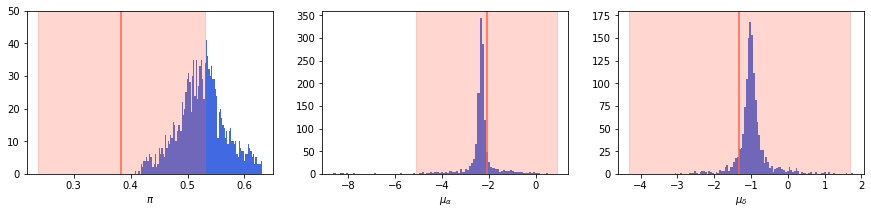

In [48]:
plot_outlier_histogram(clustered_pyupmask, mismatched_dr3[mismatched_dr3['oid']==14746998])

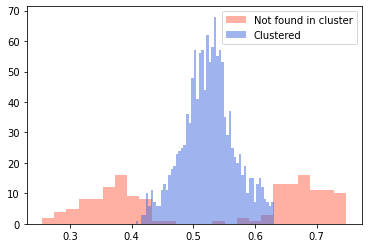

In [49]:
plt.hist(matched_dr3.parallax, bins=25, alpha=.5, color='tomato', label='Not found in cluster');
plt.hist(clustered_pyupmask.parallax, bins=55, alpha=.5, color='royalblue', label='Clustered');
plt.legend();

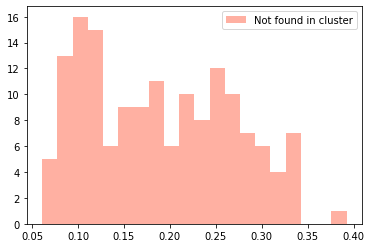

In [50]:
plt.hist(matched_dr3.parallax_err, bins=20, alpha=.5, color='tomato', label='Not found in cluster');
plt.legend();

In [51]:
np.median(matched_dr3.parallax_err)

0.1826999932527542

In [52]:
np.median(clustered_pyupmask.parallax_error)

0.042847026999999996

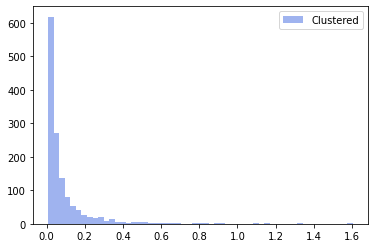

In [53]:
plt.hist(clustered_pyupmask.parallax_error, bins=55, alpha=.5, color='royalblue', label='Clustered');
plt.legend();

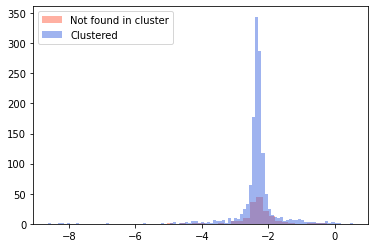

In [54]:
plt.hist(matched_dr3.pmra, bins=25, alpha=.5, color='tomato', label='Not found in cluster');
plt.hist(clustered_pyupmask.pmra, bins=100, alpha=.5, color='royalblue', label='Clustered');
plt.legend();

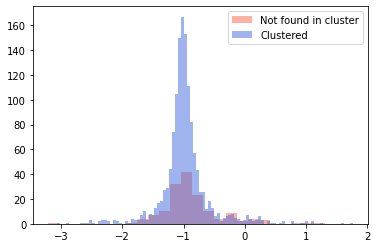

In [55]:
plt.hist(matched_dr3.pmdec, bins=25, alpha=.5, color='tomato', label='Not found in cluster');
plt.hist(clustered_pyupmask.pmdec, bins=100, alpha=.5, color='royalblue', label='Clustered');
plt.legend();

In [56]:
(dr2[dr2['EDR3 id']!=dr2['DR2 id']])

,obj_id,oid,link_bibcode,ra,dec,coo_bibcode,parallax,parallax_err,parallax_bibcode,pmra,...,pm_err,pm_bibcode,radvel,radvel_err,rvz_bibcode,ids,EDR3 id,DR2 id,TIC,reported
1121,Cl* NGC 188 PKM 7892,4922611,2018A&A...616A..10G,7.940116,84.983018,2020yCat.1350....0G,0.5955,0.3240,2020yCat.1350....0G,-1.959,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573565433249058816|Cl* NGC 188 P...,573565433249058816,5.735654e+17,NaN,1
1129,Cl* NGC 188 PKM 3192,4922896,2018A&A...616A..10G,8.339358,85.145664,2020yCat.1350....0G,0.3720,0.1170,2020yCat.1350....0G,-2.304,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573574126262853376|TIC 461595543|Cl*...,573574126262853376,5.735741e+17,461595543.0,1
1429,Gaia EDR3 573880855645340672,14748474,2018A&A...616A..10G,15.760409,85.640721,2020yCat.1350....0G,0.3879,0.3197,2020yCat.1350....0G,-2.804,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573880855645340672|Gaia DR2 57388085...,573880855645340672,5.738809e+17,NaN,1
1431,Cl* NGC 188 PKM 5888,4925665,2018A&A...616A..10G,11.981062,85.193002,2020yCat.1350....0G,0.6435,0.0514,2020yCat.1350....0G,-2.417,...,3.0,2020yCat.1350....0G,NaN,NaN,NaN,Gaia EDR3 573937892811737472|Cl* NGC 188 P...,573937892811737472,5.739379e+17,NaN,1


In [57]:
not_found.to_csv('./data/ngc_188/not_found_pyupmask.csv')

In [43]:
clustered_pyupmask['parallax'] = clustered_pyupmask['parallax'].astype(np.float32)
clustered_pyupmask['parallax_over_error'] = clustered_pyupmask['parallax_over_error'].astype(np.float32)

/tmp/ipykernel_87263/899940776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_pyupmask['parallax'] = clustered_pyupmask['parallax'].astype(np.float32)
/tmp/ipykernel_87263/899940776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_pyupmask['parallax_over_error'] = clustered_pyupmask['parallax_over_error'].astype(np.float32)


In [44]:
clustered_pyupmask = add_colors_and_abs_mag(clustered_pyupmask)

/home/mjablons/blue/extinction.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources['BP_err'] = (2.5/(np.log(10)*sources['phot_bp_mean_flux_over_error'])).astype(np.float32)
/home/mjablons/blue/extinction.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sources['RP_err'] = (2.5/(np.log(10)*sources['phot_rp_mean_flux_over_error'])).astype(np.float32)
/home/mjablons/blue/extinction.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

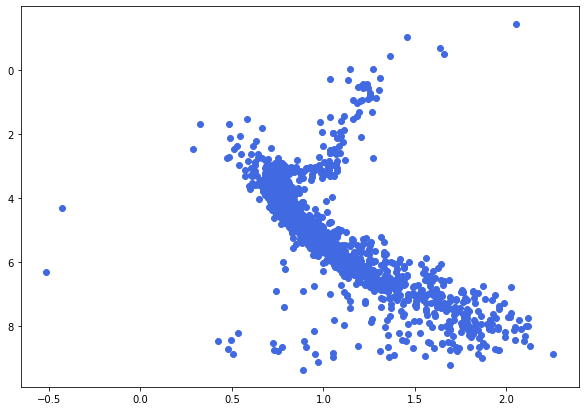

In [47]:
plt.figure(figsize=(10, 7));
plt.scatter(clustered_pyupmask.color, clustered_pyupmask.mag_abs, color='royalblue');
plt.gca().invert_yaxis();

In [48]:
clustered_pyupmask.to_csv('./clustered_pyupmask.csv')

# HDBSCAN

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=300, allow_single_cluster=True)

In [ ]:
labels_hdbscan = clusterer.fit_predict(sources_normalized)
labelled_sources_hdbscan = label_sources(sources_to_cluster, labels_hdbscan)
clustered_hdbscan, noise_hdbscan = get_clustered_and_noise(labelled_sources_hdbscan, labels_hdbscan)

r = check_for_cluster_children(from_lit_edr3, clustered_hdbscan)

In [ ]:
cluster_plot(clustered_hdbscan, noise_hdbscan, from_lit_edr3)